=== WAZE DATA STATISTICS ===
Dataset Shape: (5738, 26)
Total Records: 5,738
Total Columns: 26
Memory Usage: 4.6 MB

=== DATA QUALITY ===
Missing Values by Column:
  endTimeMillis: 5,738 (100.0%)
  startTimeMillis: 5,738 (100.0%)
  ttiFetchTimeMillis: 5,738 (100.0%)
  nThumbsUp: 5,460 (95.2%)
  city: 408 (7.1%)
  street: 165 (2.9%)
  reportDescription: 5,738 (100.0%)
  pubMillis: 5,738 (100.0%)

Columns with ALL missing values: 5
Columns with NO missing values: 18

=== CATEGORICAL VARIABLES DETAILED STATS ===

TYPE:
  Unique Values: 1
  Most Common: 'HAZARD' (5,738 times, 100.0%)
  Value Counts (Top 10):
    1. HAZARD: 5,738 (100.0%)

SUBTYPE:
  Unique Values: 6
  Most Common: 'HAZARD_ON_ROAD_OBJECT' (3,204 times, 55.8%)
  Value Counts (Top 10):
    1. HAZARD_ON_ROAD_OBJECT: 3,204 (55.8%)
    2. HAZARD_ON_ROAD_POT_HOLE: 1,383 (24.1%)
    3. HAZARD_ON_ROAD: 1,142 (19.9%)
    4. HAZARD_ON_SHOULDER_ANIMALS: 4 (0.1%)
    5. HAZARD_ON_ROAD_ROAD_KILL: 4 (0.1%)
    6. HAZARD_ON_SHOULDER: 1 (0.

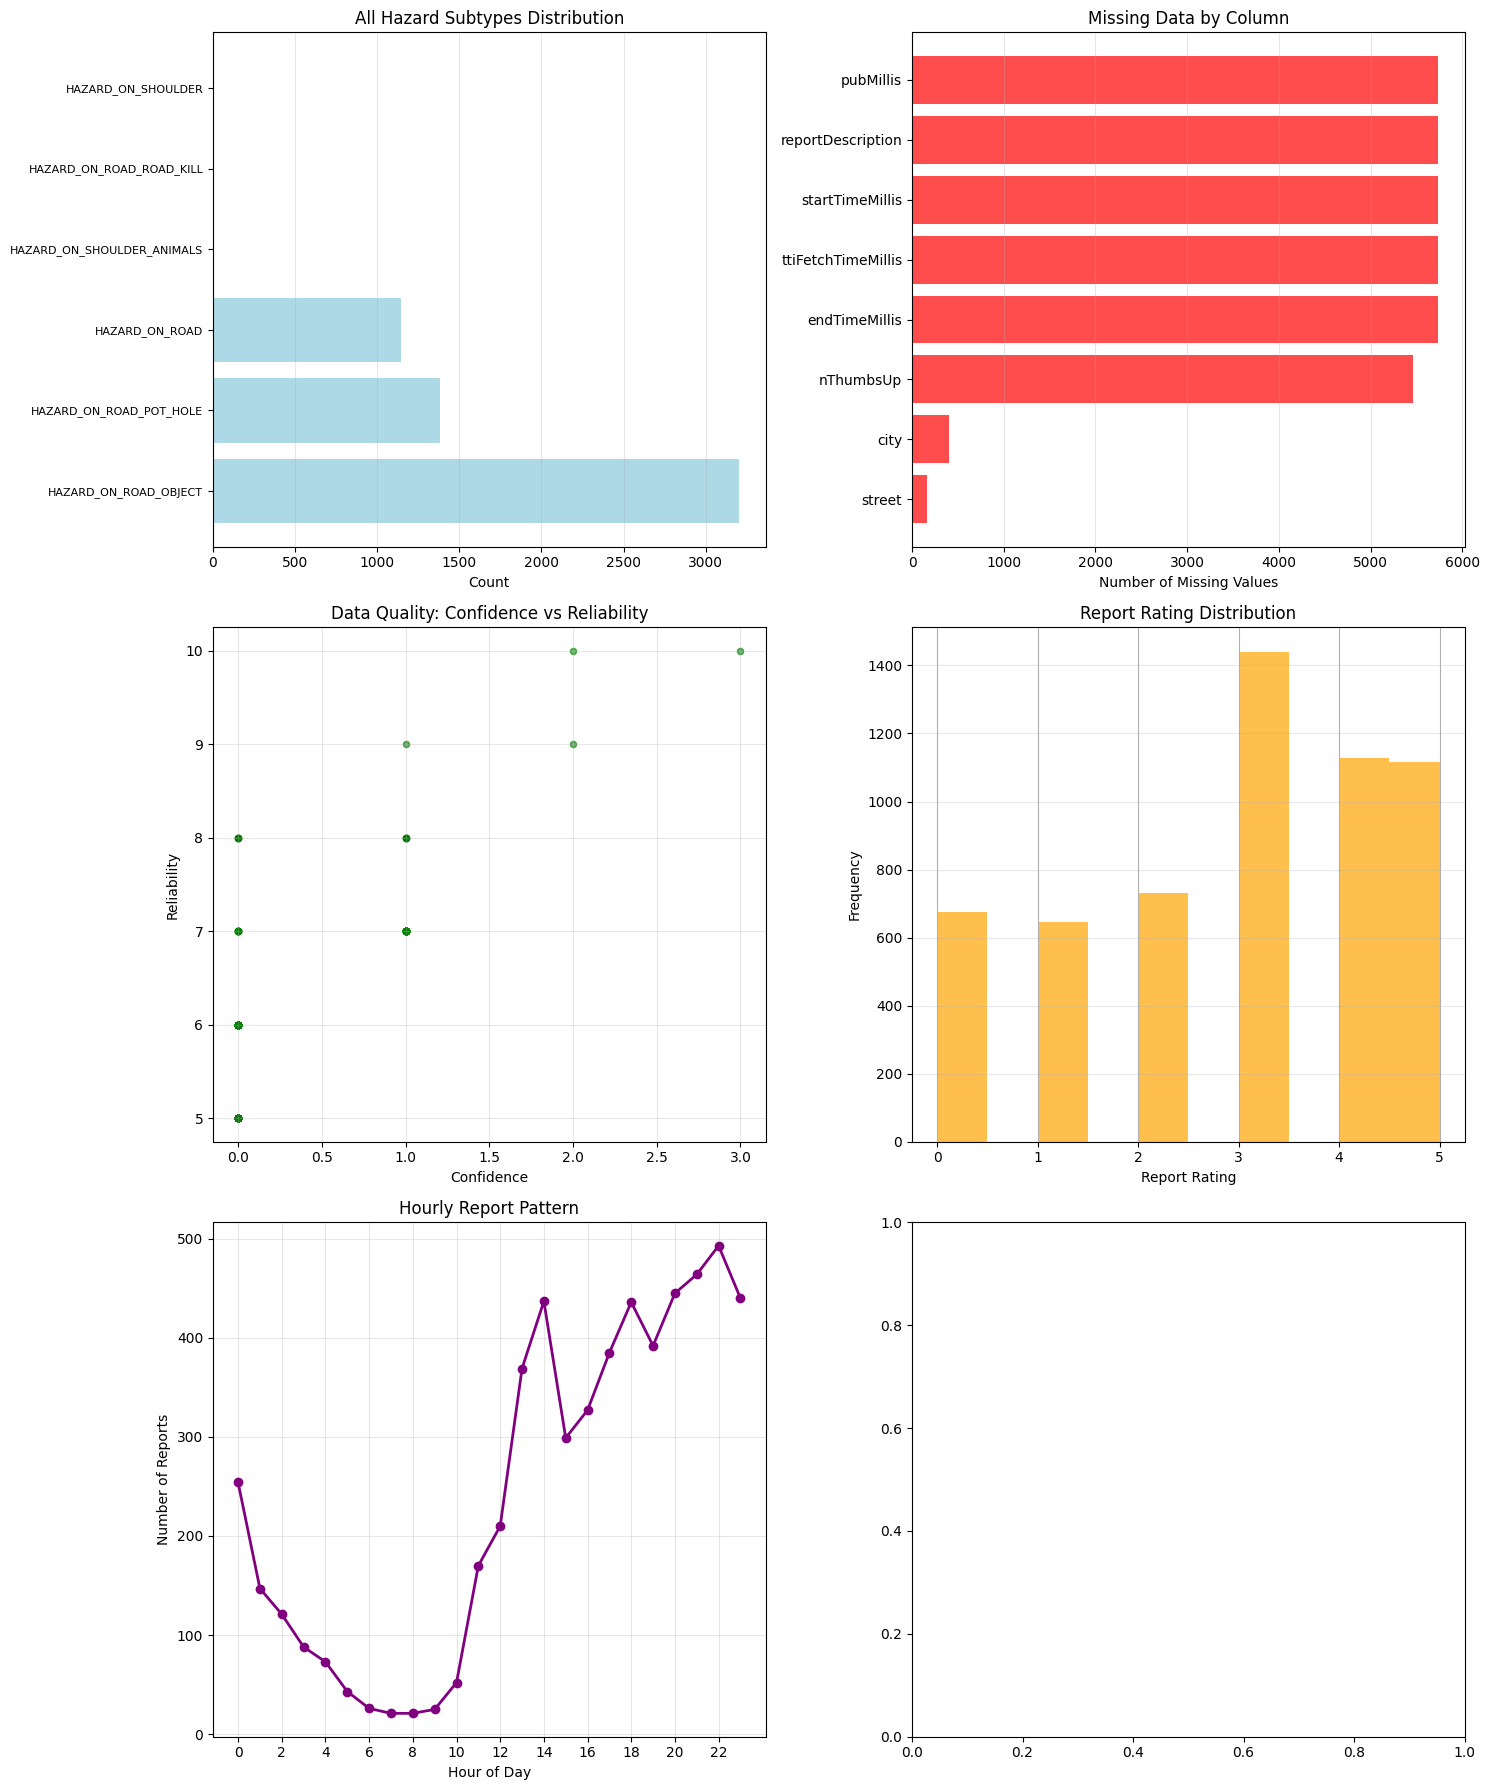


=== SUMMARY ===
This dataset contains 5,738 Waze hazard reports with 6 different subtypes.
Most reports are 'HAZARD' type with 'HAZARD_ON_ROAD_OBJECT' subtype.
Average confidence: 0.0/10, Average reliability: 5.1/10


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load data
hazards_df = pd.read_excel('Waze data type Hazards.xlsx')
with open('Waze.json', 'r') as f:
    waze_data = json.load(f)

# Clean columns
main_cols = [col for col in hazards_df.columns if '@type' not in col]
df = hazards_df[main_cols].copy()

print("=== WAZE DATA STATISTICS ===")

# BASIC INFO
print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# DATA QUALITY ASSESSMENT
print(f"\n=== DATA QUALITY ===")
missing_data = df.isnull().sum()
print("Missing Values by Column:")
for col, missing in missing_data.items():
    if missing > 0:
        pct = (missing / len(df)) * 100
        print(f"  {col}: {missing:,} ({pct:.1f}%)")

print(f"\nColumns with ALL missing values: {len([col for col, missing in missing_data.items() if missing == len(df)])}")
print(f"Columns with NO missing values: {len([col for col, missing in missing_data.items() if missing == 0])}")

# CATEGORICAL VARIABLES ANALYSIS
print(f"\n=== CATEGORICAL VARIABLES DETAILED STATS ===")
categorical_cols = ['type', 'subtype', 'country', 'city', 'street', 'reportByMunicipalityUser']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col.upper()}:")
        print(f"  Unique Values: {df[col].nunique()}")
        print(f"  Most Common: '{df[col].mode()[0]}' ({df[col].value_counts().iloc[0]:,} times, {df[col].value_counts().iloc[0]/len(df)*100:.1f}%)")
        print(f"  Value Counts (Top 10):")
        for idx, (value, count) in enumerate(df[col].value_counts().head(10).items()):
            pct = (count / len(df)) * 100
            print(f"    {idx+1}. {value}: {count:,} ({pct:.1f}%)")

# CORRELATIONS
print(f"\n=== CORRELATIONS ===")
corr_cols = ['reportRating', 'confidence', 'reliability', 'roadType', 'magvar']
corr_matrix = df[corr_cols].corr()
print("Strong correlations (|r| > 0.3):")
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"  {corr_cols[i]} ↔ {corr_cols[j]}: {corr_val:.3f}")

# BUSINESS INSIGHTS
print(f"\n=== KEY BUSINESS INSIGHTS ===")
print(f"Data Quality Score: {((len(df) - df.isnull().sum().sum()) / (len(df) * len(df.columns)) * 100):.1f}%")
print(f"Average Confidence: {df['confidence'].mean():.1f}/10")
print(f"Average Reliability: {df['reliability'].mean():.1f}/10")
print(f"Municipal vs Citizen Reports: {df['reportByMunicipalityUser'].sum():,} municipal ({df['reportByMunicipalityUser'].mean()*100:.1f}%) vs {(~df['reportByMunicipalityUser']).sum():,} citizen ({(~df['reportByMunicipalityUser']).mean()*100:.1f}%)")

# High-quality reports
high_quality = df[(df['confidence'] >= 8) & (df['reliability'] >= 8)]
print(f"High-Quality Reports (conf≥8, rel≥8): {len(high_quality):,} ({len(high_quality)/len(df)*100:.1f}%)")

# JSON COMPARISON
print(f"\n=== JSON vs EXCEL COMPARISON ===")
print(f"Excel Records: {len(df):,}")
print(f"JSON Alerts: {len(waze_data['alerts'])}")
print(f"JSON Jams: {len(waze_data['jams'])}")
print(f"JSON Irregularities: {len(waze_data['irregularities'])}")

# CREATE VISUALIZATIONS
print(f"\n=== CREATING VISUALIZATIONS ===")

# Parse time for hourly analysis
df['startTime_parsed'] = pd.to_datetime(df['startTime'], format='%Y-%m-%d %H:%M:%S:%f')
df['hour'] = df['startTime_parsed'].dt.hour

# Create subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))

# 1. All Subtypes
subtype_counts = df['subtype'].value_counts()
ax1.barh(range(len(subtype_counts)), subtype_counts.values, color='lightblue')
ax1.set_yticks(range(len(subtype_counts)))
ax1.set_yticklabels(subtype_counts.index, fontsize=8)
ax1.set_xlabel('Count')
ax1.set_title('All Hazard Subtypes Distribution')
ax1.grid(axis='x', alpha=0.3)

# 2. Missing Data Visualization
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=True)
if len(missing_counts) > 0:
    ax2.barh(range(len(missing_counts)), missing_counts.values, color='red', alpha=0.7)
    ax2.set_yticks(range(len(missing_counts)))
    ax2.set_yticklabels(missing_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Missing Values')
    ax2.set_title('Missing Data by Column')
    ax2.grid(axis='x', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No Missing Data', ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    ax2.set_title('Missing Data by Column')

# 3. Confidence vs Reliability
ax3.scatter(df['confidence'], df['reliability'], alpha=0.6, s=20, color='green')
ax3.set_xlabel('Confidence')
ax3.set_ylabel('Reliability')
ax3.set_title('Data Quality: Confidence vs Reliability')
ax3.grid(True, alpha=0.3)

# 4. Report Rating Distribution
df['reportRating'].hist(bins=10, ax=ax4, color='orange', alpha=0.7)
ax4.set_xlabel('Report Rating')
ax4.set_ylabel('Frequency')
ax4.set_title('Report Rating Distribution')
ax4.grid(axis='y', alpha=0.3)

# 5. Hourly Report Pattern
hourly_counts = df['hour'].value_counts().sort_index()
ax5.plot(hourly_counts.index, hourly_counts.values, marker='o', color='purple', linewidth=2)
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Number of Reports')
ax5.set_title('Hourly Report Pattern')
ax5.grid(True, alpha=0.3)
ax5.set_xticks(range(0, 24, 2))


plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"This dataset contains {len(df):,} Waze hazard reports with {df['subtype'].nunique()} different subtypes.")
print(f"Most reports are '{df['type'].mode()[0]}' type with '{df['subtype'].mode()[0]}' subtype.")
print(f"Average confidence: {df['confidence'].mean():.1f}/10, Average reliability: {df['reliability'].mean():.1f}/10")

In [2]:
import pandas as pd

# Ensure all rows are shown
pd.set_option('display.max_rows', None)

# Load Excel file
excel_path = "Waze data type Hazards.xlsx"
df = pd.read_excel(excel_path)

# Extract location columns
location_df = df[['location_x', 'location_y']]

# Show all rows
print(location_df)


      location_x  location_y
0     -97.169466   32.984299
1     -96.787316   32.723945
2     -96.873907   32.652348
3     -97.199023   32.995018
4     -96.912150   32.845474
5     -97.199923   32.995345
6     -97.202795   32.996201
7     -96.940579   32.596288
8     -96.508758   32.643304
9     -96.518261   32.644838
10    -96.900614   32.841946
11    -96.922764   32.612234
12    -97.181476   32.984871
13    -97.201576   32.995865
14    -97.221383   33.011895
15    -96.685394   32.714726
16    -96.709152   32.730620
17    -96.636432   32.687661
18    -96.957406   32.578727
19    -97.202311   32.996066
20    -96.846004   32.691763
21    -96.925369   32.610163
22    -96.922070   32.613158
23    -96.319883   32.581180
24    -96.923043   32.612278
25    -96.982516   32.514741
26    -96.871846   32.659872
27    -96.923433   32.611925
28    -96.632070   32.692155
29    -96.635034   32.688415
30    -96.633230   32.690270
31    -96.976343   32.491306
32    -96.866761   32.665900
33    -96.6347

In [9]:
import os
import folium
import pandas as pd
from folium.plugins import MarkerCluster

# === Load your cleaned data ===
# Uncomment and adjust the below if you're loading from Excel:
# hazards_df = pd.read_excel('Waze data type Hazard.xlsx')
# df = hazards_df[[col for col in hazards_df.columns if '@type' not in col]].copy()

print("=== CREATING WAZE DATA MAPS ===")

# === Create output directory ===
output_dir = "street_map_view"
os.makedirs(output_dir, exist_ok=True)

# === Get center for all maps ===
center_lat = df['location_y'].mean()
center_lon = df['location_x'].mean()

# -----------------------------
# ✅ MAP 2: Clustered Hazard Map
# -----------------------------
print("Creating clustered hazard map...")

m2 = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')
marker_cluster = MarkerCluster().add_to(m2)

for idx, row in df.iterrows():
    if pd.notna(row['location_x']) and pd.notna(row['location_y']):
        ppopup_text = f"""{row['subtype']}<br>
        Reliability: {row['reliability']}/10<br>
        Rating: {row['reportRating']}/5<br>
        Street: {row.get('street', 'nan')}<br>
        Time: {row['startTime']}"""
        folium.Marker(
            location=[row['location_y'], row['location_x']],
            popup=folium.Popup(popup_text, max_width=250),
            icon=folium.Icon(color='red', icon='exclamation-sign')
        ).add_to(marker_cluster)

m2.save(os.path.join(output_dir, 'waze_hazards_clustered.html'))
print("✓ Clustered hazard map saved as 'street_map_view/waze_hazards_clustered.html'")

# -----------------------------
# ✅ MAP 4: Subtype-Specific Hazard Map
# -----------------------------
print("Creating subtype-specific map...")

m4 = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

# Define colors for subtypes
subtype_colors = {
    'HAZARD_ON_ROAD_OBJECT': 'red',
    'HAZARD_ON_ROAD_POT_HOLE': 'blue',
    'HAZARD_ON_ROAD': 'orange',
    'HAZARD_ON_SHOULDER_ANIMALS': 'green',
    'HAZARD_ON_ROAD_ROAD_KILL': 'purple',
    'HAZARD_ON_SHOULDER': 'gray'
}

# Add circle markers with subtype colors
for idx, row in df.iterrows():
    if pd.notna(row['location_x']) and pd.notna(row['location_y']):
        color = subtype_colors.get(row['subtype'], 'black')
        
        popup_text = f"""{row['subtype']}<br>
        Reliability: {row['reliability']}/10<br>
        Rating: {row['reportRating']}/5<br>
        Street: {row.get('street', 'nan')}<br>
        Time: {row['startTime']}"""

        folium.CircleMarker(
            location=[row['location_y'], row['location_x']],
            radius=4,
            popup=popup_text,
            color=color,
            fill=True,
            fillOpacity=0.7
        ).add_to(m4)


# Add legend to Map 4
legend_html = '''
<div style="position: fixed; 
            top: 50px; right: 50px; width: 250px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px; box-shadow: 2px 2px 6px rgba(0,0,0,0.3)">
<b>Hazard Subtypes</b><br>
<i style="color:red;">&#9679;</i> Road Object<br>
<i style="color:blue;">&#9679;</i> Pothole<br>
<i style="color:orange;">&#9679;</i> Generic Road Hazard<br>
<i style="color:green;">&#9679;</i> Animals on Shoulder<br>
<i style="color:purple;">&#9679;</i> Roadkill<br>
<i style="color:gray;">&#9679;</i> Generic Shoulder Hazard<br>
</div>
'''

m4.get_root().html.add_child(folium.Element(legend_html))

m4.save(os.path.join(output_dir, 'waze_hazards_by_subtype.html'))
print("✓ Subtype-specific map saved as 'street_map_view/waze_hazards_by_subtype.html'")


=== CREATING WAZE DATA MAPS ===
Creating clustered hazard map...
✓ Clustered hazard map saved as 'street_map_view/waze_hazards_clustered.html'
Creating subtype-specific map...
✓ Subtype-specific map saved as 'street_map_view/waze_hazards_by_subtype.html'
